In [1]:
import os
import glob
import time
import datetime

import nibabel as nib
import numpy as np 
import tensorflow as tf
from tensorflow import keras   # Keras here
from keras import layers

import matplotlib.pyplot as plt
import numpy.random as random

In [2]:
# Sanity check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Some variables
N_VALIDATION = 1000
BATCH_SIZE = 64
# Define training data function - LIST OF NIFTIS
def get_training_data_datasets(shuffle=True):
    """
    Provides training data in the form of <filenames> and <labels>.
    Actual data are lazy-loaded at batch time.
    
    
    Inputs:
    shuffle: bool for whether to shuffle the niftis or not.
    
    Returns: 
    nii_files: A list of NIFTI files
    nii_labels: A list of binary [0,1] labels corresponding to [rejected, accepted] respectively. 
    """
    
    acc_file_loc = '/kundulab-data/dl-component-classification/meica_component_classification_experiment/dl_classify_mni/accepted/*nii.gz' #accepted file location with extension to find
    acc_loc = '/kundulab-data/dl-component-classification/meica_component_classification_experiment/dl_classify_mni/accepted' #accepted file location with extension to find'

    acc_filepaths = []
    acc_nii = []

    for i in glob.glob(acc_file_loc):
        acc_filepaths.append(i)
    for i in range(len(acc_filepaths)):
        acc_nii.append(nib.load(os.path.join(acc_loc, acc_filepaths[i]))) #acc_nii is an array of all the accepted images nifti files

    rej_file_loc = '/kundulab-data/dl-component-classification/meica_component_classification_experiment/dl_classify_mni/rejected/*nii.gz' #rej image location with extension to find
    rej_loc = '/kundulab-data/dl-component-classification/meica_component_classification_experiment/dl_classify_mni/rejected' #no extension for path.join formatting

    rej_filepaths = []
    rej_nii = []

    for i in glob.glob(rej_file_loc):
        rej_filepaths.append(i)
    for i in range(len(rej_filepaths)):
        rej_nii.append(nib.load(os.path.join(rej_loc, rej_filepaths[i]))) #rej_nii is an array of all the accepted images nifti files    
    
    # Transform from 2 sets to 1 pair of data and labels
    acc_labels = len(acc_nii)*[1]
    rej_labels = len(rej_nii)*[0]
    nii_files = acc_nii + rej_nii
    nii_labels = acc_labels + rej_labels
    
    # Testing shuffle logic
    # n_nifti_files = 1000
    # idx_shuffle = np.arange(n_nifti_files)
    # random.shuffle(idx_shuffle)
    
    # Skip this - its shuffling datasets, instead shuffle the slices of the datasets...
    #n_nifti_files = len(nii_files)
    #idx_shuffle = np.arange(n_nifti_files)
    #random.shuffle(idx_shuffle)
    #nii_files = nii_files[idx_shuffle]
    #nii_labels = nii_labels[idx_shuffle]
    
    return nii_files, nii_labels


Num GPUs Available:  1


In [3]:
def get_training_data(shuffle=True):
    """
    
    SURAJ - pull the logic of LISTING nifti filename from above, and then BELOW IS THE SHUFFLING OPERATION
    
    Return a list of tuples of form (FILENAME, SLICE_NO)
    So, from get_training_data_datasets() you get ->
    
    [
     NIFTI_1
     NIFTI_2
     ...
    ]
    [
     0
     0
     0
     ...
     1
     1
     1
    ]
    
    Here, transform into:
    
    [
     (NIFTI_1, 0, 0)
     (NIFTI_1, 1, 0)    
     (NIFTI_1, 2, 0)
     ...
     (NIFTI_1, 58, 0)
     (NIFTI_2, 0, 0)
     (NIFTI_2, 1, 0)    
     (NIFTI_2, 2, 0)
     ...
     (NIFTI_2, 58, 0)
     ...
      
     (NIFTI_1000, 0, 1)
     (NIFTI_1000, 0, 1)
     (NIFTI_1000, 1, 1)
     (NIFTI_1000, 2, 1)
     ...
     (NIFTI_1000, 58, 1)
    ]
    
    Then - shuffle that
    [
     (NIFTI_47, 20, 0)
     (NIFTI_670, 4, 1)
     ...
    ]
    
    """
    files, labels = get_training_data_datasets()
    tuple_array = []
    i=0
    for file in files:
        for slice in range(58):
            tuple_array.append([file, slice, labels[i]])
        i+=1
    random.shuffle(tuple_array)
    
    return tuple_array


In [5]:
test1 = ['file1', 'file2', 'file3', 'file4']
test2 = [1,2,3,4,5]
test3 = [0,1,0,1]

ls = []
i = 0
for file in test1:
    for slice in test2:
        ls.append([file, slice, test3[i]])
    i+=1

ls



[['file1', 1, 0],
 ['file1', 2, 0],
 ['file1', 3, 0],
 ['file1', 4, 0],
 ['file1', 5, 0],
 ['file2', 1, 1],
 ['file2', 2, 1],
 ['file2', 3, 1],
 ['file2', 4, 1],
 ['file2', 5, 1],
 ['file3', 1, 0],
 ['file3', 2, 0],
 ['file3', 3, 0],
 ['file3', 4, 0],
 ['file3', 5, 0],
 ['file4', 1, 1],
 ['file4', 2, 1],
 ['file4', 3, 1],
 ['file4', 4, 1],
 ['file4', 5, 1]]

In [6]:
# Define CNN model
def define_model():
	"""
	2-D convolutional neural network to define 2-D slices with 8-channels each
	Actual data are lazy-loaded at batch time.

	Returns:
	model: A Keras model
	"""
	model = keras.Sequential()
	model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(72, 59, 8)))
	model.add(keras.layers.MaxPooling2D((2, 2)))
	model.add(keras.layers.Flatten())
	model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(keras.layers.Dense(1, activation='sigmoid'))
	return model

In [7]:

def nii_slice_addresses_to_tf_dataframe(num_slices):
    """
    Lazy-loading for batch time.
    Pick 2-D slices to select randomly.
    
    Returns:
    A tf dataframe loaded from nii_files
    """
    
    # Suraj - complet this fcn
    tuple_array = get_training_data()
    
    # sanity check to see if the tuples change 
    print(tuple_array[0])
    
    slices = []
    val_slices=[]
    for i in range(num_slices):
        im_fdata = tuple_array[i][0].get_fdata()
        slices.append(im_fdata[tuple_array[i][1]])
        val_slices.append(im_fdata[tuple_array[i+num_slices][1]])
    
    target = [tuple_array[i][2] for i in range(num_slices)]
    val_target = [tuple_array[i+num_slices][2] for i in range(num_slices)]
    print(len(target))

    # train_dataset = tf.data.Dataset.from_tensor_slices((slices, target))
    # train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    
       
    return slices, target, val_slices, val_target

Memory_batch: 0

[<nibabel.nifti1.Nifti1Image object at 0x7f02282d5290>, 24, 1]
1500
Size of x_group: 100
Size of y_group: 100
Size of x_val: 100
Size of y_val: 100
--------------Epoch 0------------------
0
Training loss (for one batch) at step 0: 296.6139
Seen so far: 100 samples
Training acc over epoch: 0.4900
Validation acc: 0.4300
--------------Epoch 1------------------
0
Training loss (for one batch) at step 0: 1186.3457
Seen so far: 100 samples
Training acc over epoch: 0.5250
Validation acc: 0.4200
--------------Epoch 2------------------
0
Training loss (for one batch) at step 0: 93.9575
Seen so far: 100 samples
Training acc over epoch: 0.5767
Validation acc: 0.4733
--------------Epoch 3------------------
0
Training loss (for one batch) at step 0: 108.0572
Seen so far: 100 samples
Training acc over epoch: 0.6200
Validation acc: 0.5025
--------------Epoch 4------------------
0
Training loss (for one batch) at step 0: 91.7024
Seen so far: 100 samples
Training acc over epoch: 0.6320

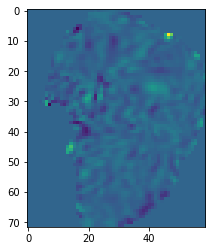

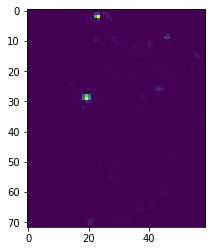

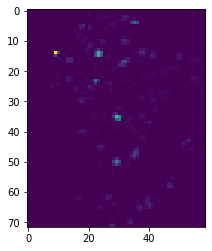

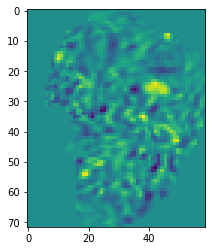

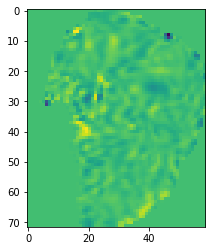

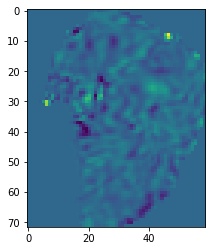

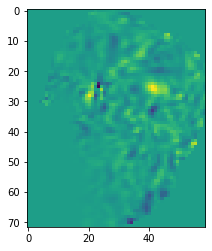

Memory_batch: 1

[<nibabel.nifti1.Nifti1Image object at 0x7f029c3dc590>, 46, 1]
1500
Size of x_group: 100
Size of y_group: 100
Size of x_val: 100
Size of y_val: 100
--------------Epoch 0------------------
0
Training loss (for one batch) at step 0: 642.1520
Seen so far: 100 samples
Training acc over epoch: 0.9709
Validation acc: 0.4289
--------------Epoch 1------------------
0
Training loss (for one batch) at step 0: 138.1459
Seen so far: 100 samples
Training acc over epoch: 0.9676
Validation acc: 0.4297
--------------Epoch 2------------------
0
Training loss (for one batch) at step 0: 8.1269
Seen so far: 100 samples
Training acc over epoch: 0.9661
Validation acc: 0.4305
--------------Epoch 3------------------
0
Training loss (for one batch) at step 0: 4.2744
Seen so far: 100 samples
Training acc over epoch: 0.9655
Validation acc: 0.4310
--------------Epoch 4------------------
0
Training loss (for one batch) at step 0: 3.4884
Seen so far: 100 samples
Training acc over epoch: 0.9650
Vali

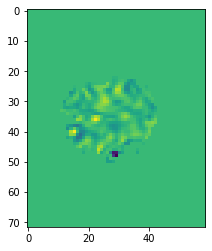

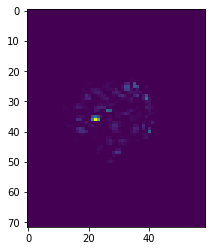

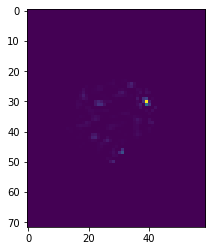

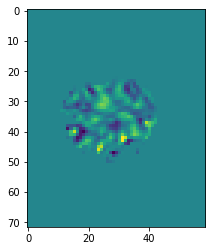

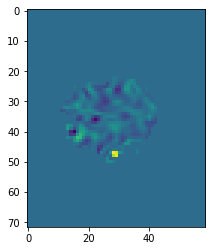

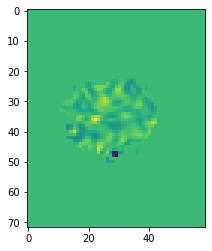

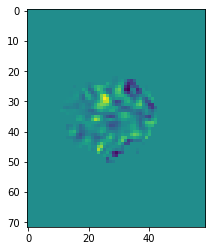

Memory_batch: 6

[<nibabel.nifti1.Nifti1Image object at 0x7f02280a4d50>, 36, 0]
1500
Size of x_group: 100
Size of y_group: 100
Size of x_val: 100
Size of y_val: 100
--------------Epoch 0------------------
0
Training loss (for one batch) at step 0: 795.2617
Seen so far: 100 samples
Training acc over epoch: 0.9763
Validation acc: 0.4826
--------------Epoch 1------------------
0
Training loss (for one batch) at step 0: 423.1880
Seen so far: 100 samples
Training acc over epoch: 0.9759
Validation acc: 0.4825
--------------Epoch 2------------------
0
Training loss (for one batch) at step 0: 145.5013
Seen so far: 100 samples
Training acc over epoch: 0.9757
Validation acc: 0.4825
--------------Epoch 3------------------
0
Training loss (for one batch) at step 0: 40.7892
Seen so far: 100 samples
Training acc over epoch: 0.9755
Validation acc: 0.4824
--------------Epoch 4------------------
0
Training loss (for one batch) at step 0: 12.4008
Seen so far: 100 samples
Training acc over epoch: 0.9754


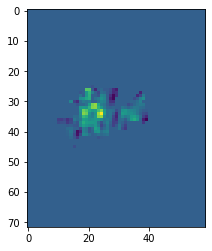

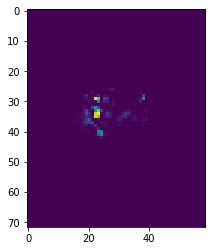

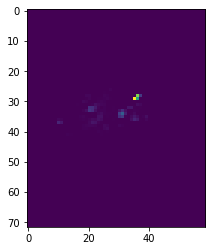

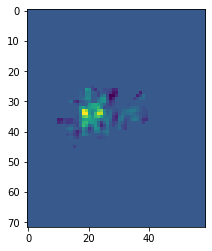

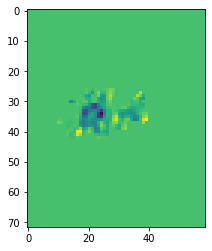

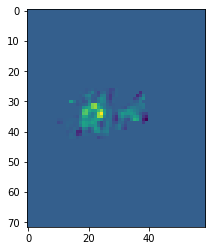

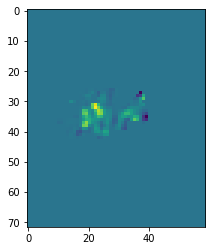

Memory_batch: 11

[<nibabel.nifti1.Nifti1Image object at 0x7f02084592d0>, 44, 1]
1500
Size of x_group: 100
Size of y_group: 100
Size of x_val: 100
Size of y_val: 100
--------------Epoch 0------------------
0
Training loss (for one batch) at step 0: 705.6795
Seen so far: 100 samples
Training acc over epoch: 0.9788
Validation acc: 0.4835
--------------Epoch 1------------------
0
Training loss (for one batch) at step 0: 225.8271
Seen so far: 100 samples
Training acc over epoch: 0.9785
Validation acc: 0.4834
--------------Epoch 2------------------
0
Training loss (for one batch) at step 0: 98.3276
Seen so far: 100 samples
Training acc over epoch: 0.9783
Validation acc: 0.4834
--------------Epoch 3------------------
0
Training loss (for one batch) at step 0: 24.1221
Seen so far: 100 samples
Training acc over epoch: 0.9782
Validation acc: 0.4834
--------------Epoch 4------------------
0
Training loss (for one batch) at step 0: 6.7112
Seen so far: 100 samples
Training acc over epoch: 0.9780
V

In [10]:
# Suraj - finish this
EPOCHS = 100
BATCH_SIZE = 100
MEMORY_GROUP_SIZE = 15

tuples = get_training_data()
N_TOTAL_SLICES = len(tuples)

N_MEMORY_SIZE = BATCH_SIZE * MEMORY_GROUP_SIZE    # how many slices you want to load into memory at any time, like 500
#N_MEMORY_GROUPS = N_TOTAL_SLICES // N_MEMORY_SIZE # THIS IS INTEGER FOR THE # OF GROUPS OF SLICES
N_MEMORY_GROUPS = N_MEMORY_SIZE // BATCH_SIZE  
                                                  # TO LOAD _AND_ DEL.
                                                  # note in Python 3,
                                                  #  // means give integer, not float

model = define_model()   

# Instantiate an optimizer.
optimizer = keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

#Setting up the tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


#OUTER OUTER LOOP - JUST FOR MEMORY MANAGEMENT
for memory_batch in range(N_MEMORY_GROUPS):
    print('Memory_batch: '+str(memory_batch)+'\n')
    slices, target, val_slices, val_targets = nii_slice_addresses_to_tf_dataframe(N_MEMORY_SIZE)
    x_group = slices[memory_batch * BATCH_SIZE : (memory_batch+1) * BATCH_SIZE]
    y_group = target[memory_batch * BATCH_SIZE : (memory_batch+1) * BATCH_SIZE]

    print("Size of x_group: "+ str(len(x_group)))
    print("Size of y_group: "+ str(len(y_group)))
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_group, y_group))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

    x_val = val_slices[memory_batch * BATCH_SIZE : (memory_batch+1) * BATCH_SIZE]
    y_val = val_targets[memory_batch * BATCH_SIZE : (memory_batch+1) * BATCH_SIZE]

    print("Size of x_val: "+ str(len(x_val)))
    print("Size of y_val: "+ str(len(y_val)))
 
    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    
    #OUTER LOOP
    for epoch in range(EPOCHS):
        print('--------------Epoch '+ str(epoch) +'------------------')
        #INNER LOOP        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                

                        # Run the forward pass of the layer.
                        # The operations that the layer applies
                        # to its inputs are going to be recorded
                        # on the GradientTape.
                logits = model(x_batch_train, training=True)  # Logits for this minibatch

                        # Compute the loss value for this minibatch.
                y_batch_train = np.reshape([y_batch_train], (len(y_batch_train), 1))                        
                loss_value = loss_fn(y_batch_train, logits)

                    # Use the gradient tape to automatically retrieve
                    # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)

                    # Run one step of gradient descent by updating
                    # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            train_acc_metric.update_state(y_batch_train, logits)
            
            # # %%
            # if epoch % 100 == 0:
            #     img = slices[0]
            #     for i in range(7):
            #         plt.imshow(img[:,:,i])
            #         plt.show()
                
        

                    # Log every 200 batches.

            print(step)    
            if step % 100 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))
        
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            with train_summary_writer.as_default():
                tf.summary.scalar('accuracy', train_acc, step=epoch)
                # Run a validation loop at the end of each epoch.

            step += 1

        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=True) #False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        val_acc = val_acc_metric.result()
        #val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        tf.summary.scalar('val_accuracy', val_acc, step=epoch)

        
    # %%
    if memory_batch % 5 == 0:
        img = slices[0]
        for i in range(7):
            plt.imshow(img[:,:,i])
            plt.show()        